# 1-st order ODE
$$ \dfrac{d^2 y}{d x^2} = f(x) \\ \\  y(0) = y_{0}, \dfrac{d y}{d x} (0) = y_{0}^{'} $$

Assume, that $ y_0, y_0^{'} $ - fuzzy number. For convenience, membership function of $ a $ is triangular function.
Of course, we can solve it equation, for every $ \alpha - cut $ : $ \left ( a_{left}^i, a_{right}^i \right ) $

Numerical solution of this equation in simpliest way is euler-scheme : $ y_{i + 1} = {\Delta x}^2 f(x, y_{i}) + 2 y_{i} - y_{i - 1} $ and from derevative approximation : $ y_1 = y_{0}^{'} \Delta x + y_{0} $

In [107]:
import numpy as np
import matplotlib.pyplot as plt

In [170]:
def f(_x):
    return 0.1

In [231]:
X = 1
steps = 20
y_0, y_1 = 2, -1

h_x = X / steps
x = np.linspace(0, X, steps)
y = np.zeros(steps)

y[0] = y_0
y[1] = h_x * y_1 + y_0

In [232]:
for i in range(2, steps):
    y[i] = h_x ** 2 * f(x[i]) + 2 * y[i - 1] - y[i - 2]

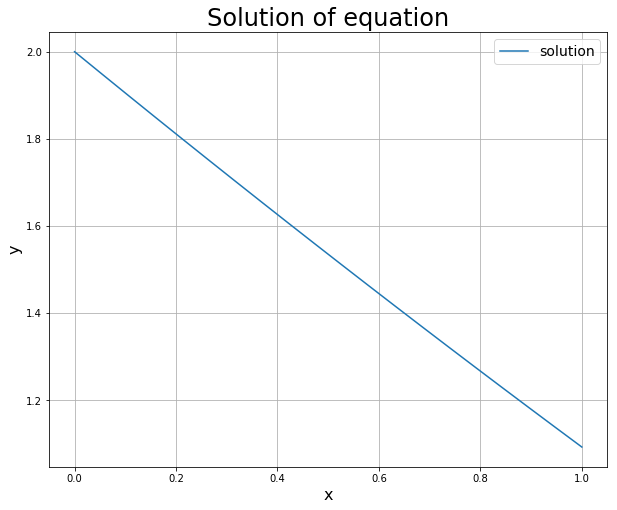

In [233]:
plt.figure(figsize=(10, 8))
plt.plot(x, y, label='solution')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Solution of equation', fontsize=24)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [234]:
import skfuzzy

In [195]:
import fuzzy_nums
from fuzzy_nums import FuzzyNumber
from fuzzy_nums.MFs import TrapMF, TriMF
from fuzzy_nums.Arithmetics import ArithmeticController

In [255]:
sections = 250
f1, f2 = FuzzyNumber(sections=sections), FuzzyNumber(sections=sections)
arithmetic_controller = ArithmeticController()
mf_1 = TriMF(y_0 * 0.9, y_0, y_0 * 1.1)
mf_2 = TriMF(y_1 * 0.9, y_1, y_1 * 1.1)

f1.set_mf(mf_1)
f2.set_mf(mf_2)

In [256]:
y = list()
y.append(f1)

f3 = f1 * h_x + f2

y.append(f3)

In [257]:
for i in range(2, steps):
    
    f1 = y[i - 2]
    f2 = y[i - 1]
    
    z = f1 + f2
    z = z * (-1) + h_x ** 2 * f(x[i])
    y.append(z)

In [258]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

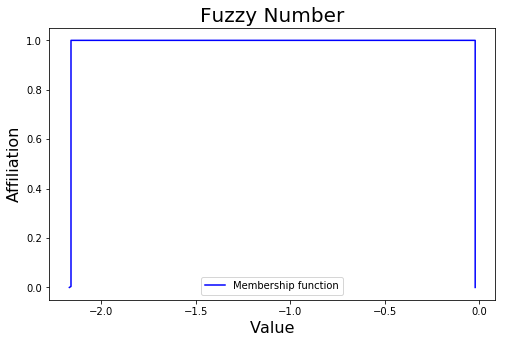

In [263]:
y[5].plot_mf()

# C-Means

In [7]:
import pandas as pd
import numpy as np

In [6]:
data = pd.read_excel('data.xls')
data.head()

,среднее Q за янв /среднее Q за год,среднее Q за июль/среднее Q за год
1. Дно,1.941622,0.369397
2.Полоное,1.379451,1.993568
3.Порхов,2.076521,2.587843
4.Дедовичи,1.249001,1.652473
5.Бежаницы,2.374301,2.968931


In [95]:
Q = data.values[:, 0:]

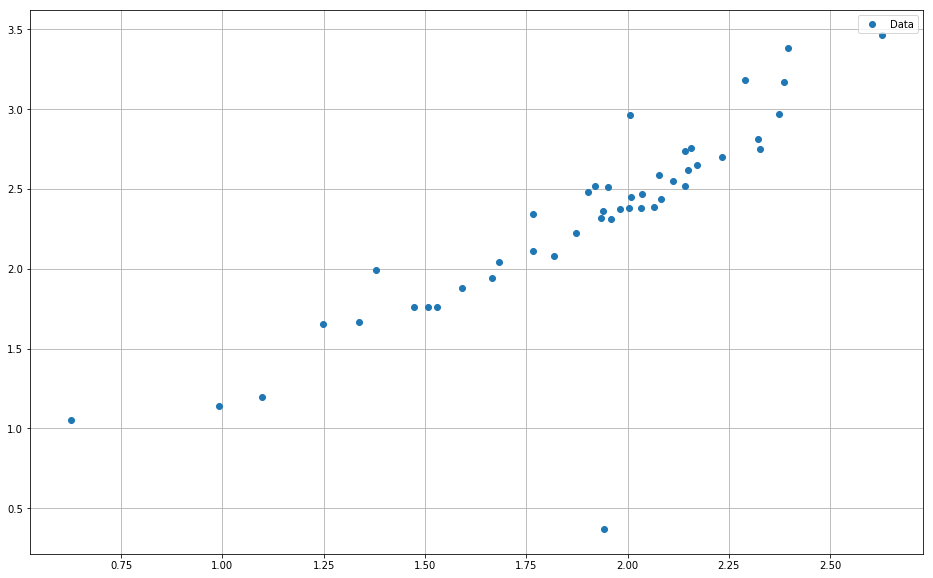

In [224]:
plt.figure(figsize=(16, 10))
plt.plot(Q[:, 0], Q[:, 1], 'o', label='Data')
plt.grid()
plt.legend()
plt.show()

In [213]:
def FCM(observations, clusters=3, tol=1e-3, max_iter=25):
    
    u = np.random.uniform(low=0, high=1, size=(observations.shape[0], clusters))
    centers = np.zeros((clusters, observations.shape[1]))
    
    def update_centers(observations, u, centers, power=1):
        rows, cols = u.shape
        for j in range(cols):
            c_j = observations[0, :] * np.power(u[0, j], power)
            for i in range(1, rows):
                c_j += observations[i, :] * np.power(u[i, j], power)
                
            c_j /= np.sum(np.power(u[:, j], power))
            
            centers[j, :] = c_j
        
        return centers
    
    def update_mf_matrix(observations, u, centers, power=1):
        classes = np.zeros(observations.shape[0])
        rows, cols = u.shape
        for i in range(rows):
            for j in range(cols):
                x = observations[i, :]
                c_i = centers[j, :]
                
                over_part = np.linalg.norm(x - c_i)
                
                result = 0
                for k in range(clusters):
                    c_k = centers[k, :]
                    
                    add = over_part / np.linalg.norm(x - c_k)
                    add = np.power(add, power)
                    result += add
                
                u[i, j] = 1 / result
                
            classes[i] = np.argmax(u[i, :])
            
        return u, classes
    
    def loss(observations, u, centers, power=1):
        rows, cols = u.shape
        _loss = 0
        for i in range(rows):
            for j in range(cols):
                x = observations[i, :]
                c = centers[j, :]
                l = np.power(u[i, j], power) * np.linalg.norm(x - c) ** 2
                
                _loss += l
                
        return _loss
    
    err = 1
    iteration = 1
    
    errors = [loss(observations, u, centers, power=0)]
    
    while err > tol and iteration < max_iter:

        centers = update_centers(observations, u, centers, power=iteration)
        u, classes = update_mf_matrix(observations, u, centers, power=2 / (iteration))
        l = loss(observations, u, centers, power=iteration)
        
        errors.append(l)
        
        err = np.abs(l)
        iteration += 1
    
    errors = np.array(errors)
    
    return classes, centers, u, errors

In [222]:
def plot_FCM_results(data, max_clusters=4):
    
    fig, axs = plt.subplots(nrows=np.int(max_clusters / 2), ncols=2)
    fig.set_figwidth(16)
    fig.set_figheight(8 * max_clusters // 2)
    
    for clusters, ax in zip(range(1, max_clusters + 1), axs.flatten()):
        classes, centers, u, errors = FCM(data, clusters=clusters, tol=1e-5, max_iter=100)
        for cluster in range(clusters):
            cluster_data = data[np.where(classes == cluster), :][0]
            ax.plot(cluster_data[:, 0], cluster_data[:, 1], 'o', label='Cluster {}'.format(cluster + 1))
        ax.legend()
        ax.grid()
    
    plt.show()

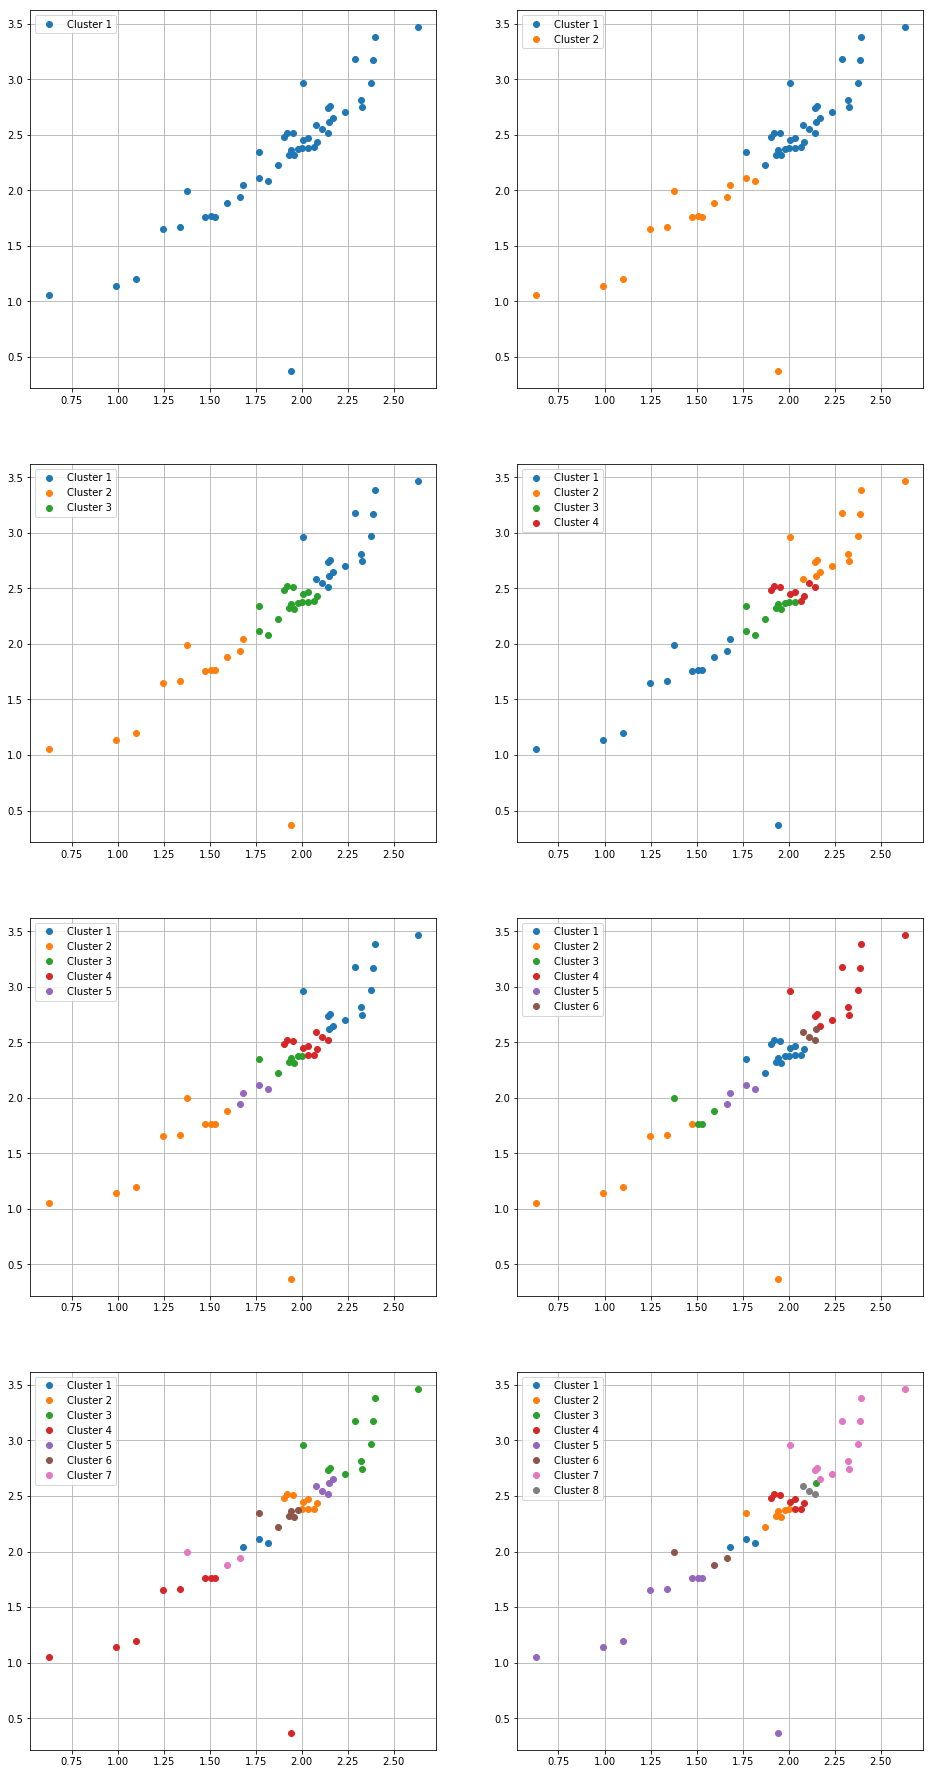

In [223]:
plot_FCM_results(Q, max_clusters=8)

Reference: https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/cmeans.html